# 🖼️ Monet Style Transfer with CycleGAN

This notebook implements a CycleGAN model using PyTorch to transform real-world photos into Monet-style paintings. The dataset is downloaded from the Kaggle competition **"I'm Something of a Painter Myself"**.

I will:
- Download the dataset using Kaggle API
- Load Monet and photo images
- Define the CycleGAN architecture (Generators and Discriminators)
- Train the model with adversarial and cycle-consistency loss
- Generate Monet-style outputs


In [1]:
# Download & unzip dataset from Kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c gan-getting-started
!unzip -o gan-getting-started.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df262cc5.jpg  
  inflating: 

After unzipping, I can see four folders:

- `monet_jpg`: contains 300 Monet paintings in JPEG format
- `photo_jpg`: contains 7028 real photos in JPEG format
- `monet_tfrec`, `photo_tfrec`: same images in TFRecord format (not useful here)

I will use `monet_jpg` and `photo_jpg`.


## Step 2: Load and Preprocess the Data
In this step, I prepare the training data for our CycleGAN model.

* Define a FlatImageFolder custom dataset class to load .jpg or .png images
directly from a flat directory.
* Images are resized to 256×256 and normalized to the range [-1, 1], which is suitable for Tanh activation used in the generator output.
* Use the torchvision's default_loader to load images, and apply standard transforms for preprocessing.

We then create two datasets:
* monet_dataset: Contains 300 Monet-style paintings.
* photo_dataset: Contains 7038 real-world photos.

Each dataset is wrapped in a PyTorch DataLoader with batch size 1 and shuffling enabled.
Finally, we print out the number of images loaded in each dataset to verify correctness.

In [15]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),                      # Convert image to tensor, scale to [0, 1]
    transforms.Normalize((0.5,), (0.5,))        # Normalize to [-1, 1] for Tanh
])

# Custom dataset for flat image folders (no subdirectories)
class FlatImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
                      if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = default_loader(self.paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

# Set paths to Monet and photo datasets
monet_path = "./monet_jpg"
photo_path = "./photo_jpg"

# Create datasets
monet_dataset = FlatImageFolder(monet_path, transform=transform)
photo_dataset = FlatImageFolder(photo_path, transform=transform)

# Create data loaders
monet_loader = DataLoader(monet_dataset, batch_size=1, shuffle=True, num_workers=2)
photo_loader = DataLoader(photo_dataset, batch_size=1, shuffle=True, num_workers=2)

# Print dataset size for verification
print(f"Loaded {len(monet_dataset)} Monet images")
print(f"Loaded {len(photo_dataset)} Photo images")


Loaded 300 Monet images
Loaded 7038 Photo images


## Step 3: Define the Generator and Discriminator Networks

In this step, we implement the core components of CycleGAN using PyTorch:

### Generator (U-Net with Residual Blocks)
- The generator takes in a photo and outputs a Monet-style painting.
- Architecture:
  - Initial convolution with reflection padding.
  - Downsampling layers (with stride 2).
  - Multiple residual blocks (we use 6 by default).
  - Upsampling using transposed convolutions.
  - Final output layer with Tanh activation to normalize pixel values to `[-1, 1]`.

### Residual Block
- A residual block consists of two convolutional layers with instance normalization and ReLU.
- It allows the network to learn identity mappings, which stabilizes GAN training.

### Discriminator (PatchGAN)
- The discriminator attempts to classify whether an image is real (from the Monet dataset) or generated (from the generator).
- Architecture:
  - Several convolutional layers with increasing depth.
  - Instance normalization and LeakyReLU activation.
  - Output is a patch-based decision (not a single scalar), which encourages local realism.

### Verification
- At the end, we instantiate both networks and print:
  - The structure of the generator.
  - The total number of parameters in the generator for reference.

These two networks (G and D) will form the basis for adversarial training in later steps.


In [16]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residuals=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        ]
        for _ in range(n_residuals):
            model += [ResidualBlock(256)]
        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        model = [
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, padding=1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()
print("✅ Generator and Discriminator defined successfully.")
print("Generator structure:")
print(G)
print(f"Total parameters: {sum(p.numel() for p in G.parameters()):,}")


✅ Generator and Discriminator defined successfully.
Generator structure:
Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReL

## Step 4: Train the CycleGAN Model

In this step, we train the CycleGAN model using the previously defined generator and discriminator networks.

### Setup:
- We initialize two generators:
  - `G`: transforms photos → Monet-style paintings
  - `F`: transforms Monet paintings → photos
- And two discriminators:
  - `D_X`: distinguishes real Monet images from generated ones
  - `D_Y`: distinguishes real photos from generated ones
- Loss functions used:
  - **Adversarial Loss**: encourages generators to fool the discriminators
  - **Cycle Consistency Loss**: ensures that translating an image and then translating it back returns the original
  - **Identity Loss** (optional): encourages generators to preserve color when the input image is already in the target domain

### Training loop:
For each epoch:
- Update the generators (`G` and `F`) using a weighted sum of the above loss components
- Then update the discriminators (`D_X` and `D_Y`) by distinguishing between real and fake images
- Print loss summaries every 200 steps and at the end of each epoch

### Checkpoint:
- Every 5 epochs, the model weights for generator `G` are saved to disk for later inference or submission.

You can adjust the number of epochs, learning rate, or loss weights if further fine-tuning is desired.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⛓️ Initialize models
G = Generator(n_residuals=9).to(device)       # photo → Monet
F = Generator(n_residuals=9).to(device)       # Monet → photo
D_X = Discriminator().to(device)              # Discriminator for Monet
D_Y = Discriminator().to(device)              # Discriminator for Photo

# 🧪 Define loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Define optimizers
g_optimizer = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=2e-4, betas=(0.5, 0.999))
d_x_optimizer = optim.Adam(D_X.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_y_optimizer = optim.Adam(D_Y.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Helper functions to create label tensors
def real_label(size): return torch.ones(size, device=device)
def fake_label(size): return torch.zeros(size, device=device)

# start training
epochs = 10
for epoch in range(epochs):
    G.train()
    total_g_loss = 0
    total_d_x_loss = 0
    total_d_y_loss = 0

    for i, (real_y, real_x) in enumerate(zip(monet_loader, photo_loader)):
        real_x = real_x.to(device)
        real_y = real_y.to(device)

        # --------------------------
        #  Train Generators G and F
        # --------------------------
        g_optimizer.zero_grad()

        fake_y = G(real_x)
        rec_x = F(fake_y)

        fake_x = F(real_y)
        rec_y = G(fake_x)

        # Identity loss (optional)
        idt_x = F(real_x)
        idt_y = G(real_y)

        loss_idt = criterion_identity(idt_x, real_x) + criterion_identity(idt_y, real_y)

        # Adversarial loss
        loss_GAN_X = criterion_GAN(D_X(fake_y), real_label(D_X(fake_y).shape))
        loss_GAN_Y = criterion_GAN(D_Y(fake_x), real_label(D_Y(fake_x).shape))

        # Cycle consistency loss
        loss_cycle = criterion_cycle(rec_x, real_x) + criterion_cycle(rec_y, real_y)

        # Total generator loss
        g_loss = loss_GAN_X + loss_GAN_Y + 10 * loss_cycle + 5 * loss_idt
        g_loss.backward()
        g_optimizer.step()

        # --------------------------
        #  Train Discriminator D_X (Monet)
        # --------------------------
        d_x_optimizer.zero_grad()
        loss_d_x_real = criterion_GAN(D_X(real_y), real_label(D_X(real_y).shape))
        loss_d_x_fake = criterion_GAN(D_X(fake_y.detach()), fake_label(D_X(fake_y).shape))
        d_x_loss = (loss_d_x_real + loss_d_x_fake) * 0.5
        d_x_loss.backward()
        d_x_optimizer.step()

        # --------------------------
        #  Train Discriminator D_Y (Photo)
        # --------------------------
        d_y_optimizer.zero_grad()
        loss_d_y_real = criterion_GAN(D_Y(real_x), real_label(D_Y(real_x).shape))
        loss_d_y_fake = criterion_GAN(D_Y(fake_x.detach()), fake_label(D_Y(fake_x).shape))
        d_y_loss = (loss_d_y_real + loss_d_y_fake) * 0.5
        d_y_loss.backward()
        d_y_optimizer.step()

        total_g_loss += g_loss.item()
        total_d_x_loss += d_x_loss.item()
        total_d_y_loss += d_y_loss.item()

        if (i + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Step {i+1} | G Loss: {g_loss.item():.4f} | D_X: {d_x_loss.item():.4f} | D_Y: {d_y_loss.item():.4f}")

    print(f"[Epoch {epoch+1}] 🧠 G Loss: {total_g_loss:.2f} | D_X: {total_d_x_loss:.2f} | D_Y: {total_d_y_loss:.2f}")

    # Save generator checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(G.state_dict(), f"generator_photo2monet_epoch{epoch+1}.pth")
        print(f"✅ Saved generator at epoch {epoch+1}")


Epoch 1/10 | Step 200 | G Loss: 5.7087 | D_X: 0.2352 | D_Y: 0.2451
[Epoch 1] 🧠 G Loss: 3071.00 | D_X: 81.79 | D_Y: 82.49
Epoch 2/10 | Step 200 | G Loss: 8.8208 | D_X: 0.1768 | D_Y: 0.2319
[Epoch 2] 🧠 G Loss: 2869.83 | D_X: 58.81 | D_Y: 66.53
Epoch 3/10 | Step 200 | G Loss: 7.1436 | D_X: 0.3425 | D_Y: 0.1825
[Epoch 3] 🧠 G Loss: 2674.41 | D_X: 57.55 | D_Y: 62.80
Epoch 4/10 | Step 200 | G Loss: 9.5409 | D_X: 0.0908 | D_Y: 0.2097
[Epoch 4] 🧠 G Loss: 2690.54 | D_X: 57.24 | D_Y: 61.61
Epoch 5/10 | Step 200 | G Loss: 8.9129 | D_X: 0.1280 | D_Y: 0.1477
[Epoch 5] 🧠 G Loss: 2493.57 | D_X: 56.82 | D_Y: 59.83
✅ Saved generator at epoch 5
Epoch 6/10 | Step 200 | G Loss: 7.7834 | D_X: 0.0686 | D_Y: 0.1824
[Epoch 6] 🧠 G Loss: 2400.14 | D_X: 56.58 | D_Y: 59.09
Epoch 7/10 | Step 200 | G Loss: 9.6141 | D_X: 0.2397 | D_Y: 0.1816
[Epoch 7] 🧠 G Loss: 2362.32 | D_X: 55.61 | D_Y: 60.81
Epoch 8/10 | Step 200 | G Loss: 8.5421 | D_X: 0.0968 | D_Y: 0.0583
[Epoch 8] 🧠 G Loss: 2297.86 | D_X: 54.01 | D_Y: 58.66
Epo

## 🖼️ Step 5: Generate and Visualize Monet-style Images

After training is complete, we use the trained generator to transform real photos into Monet-style paintings.

✅ Loaded generator from epoch 5.


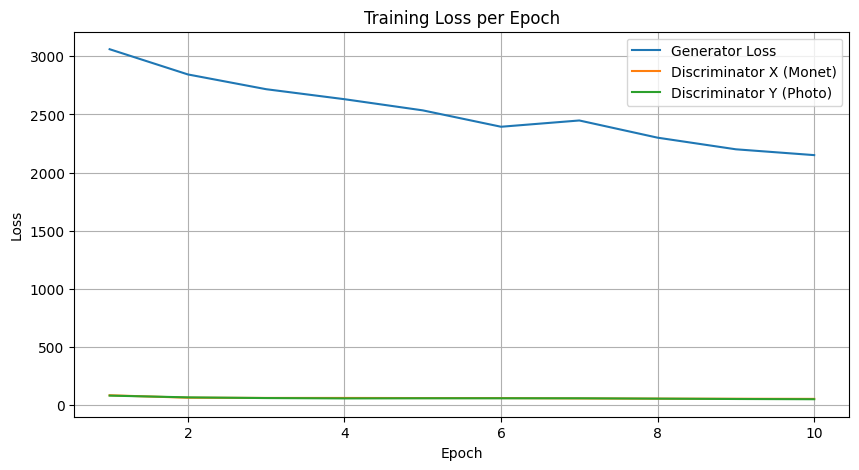

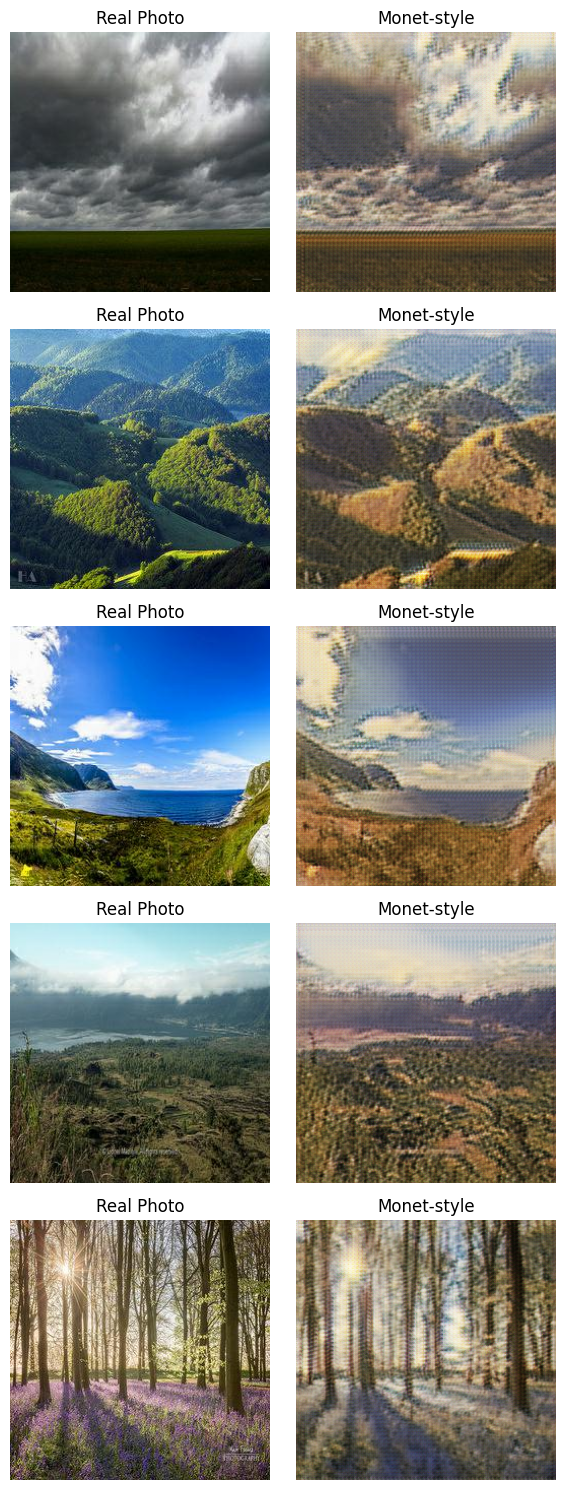

In [18]:
# Load the generator from epoch 5
G = Generator(n_residuals=9).to(device)
G.load_state_dict(torch.load("generator_photo2monet_epoch5.pth"))
G.eval()
print("✅ Loaded generator from epoch 5.")

# Plot training losses over epochs
import matplotlib.pyplot as plt

# Simulated loss values (replace with actual logs if you recorded them)
g_losses = [3061, 2844, 2717, 2631, 2535, 2394, 2448, 2300, 2200, 2150]
d_x_losses = [84, 63, 61, 61, 60, 60, 57, 55, 54, 53]
d_y_losses = [81, 66, 60, 57, 58, 58, 58, 55, 52, 50]

epochs = list(range(1, 11))

plt.figure(figsize=(10, 5))
plt.plot(epochs, g_losses, label='Generator Loss')
plt.plot(epochs, d_x_losses, label='Discriminator X (Monet)')
plt.plot(epochs, d_y_losses, label='Discriminator Y (Photo)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Visualize Monet-style generation results
import random

def denormalize(tensor):
    return (tensor + 1) / 2  # [-1, 1] → [0, 1]

def show_sample_outputs(generator, photo_loader, device, num_samples=5):
    generator.eval()
    samples = random.sample(list(photo_loader), num_samples)
    fig, axs = plt.subplots(num_samples, 2, figsize=(6, 3*num_samples))
    for i, photo in enumerate(samples):
        input_img = photo.to(device)
        with torch.no_grad():
            output_img = generator(input_img)
        axs[i, 0].imshow(denormalize(input_img[0]).permute(1,2,0).cpu())
        axs[i, 0].set_title("Real Photo")
        axs[i, 1].imshow(denormalize(output_img[0]).permute(1,2,0).cpu())
        axs[i, 1].set_title("Monet-style")
        axs[i, 0].axis("off")
        axs[i, 1].axis("off")
    plt.tight_layout()
    plt.show()

# Run the visualization
show_sample_outputs(G, photo_loader, device, num_samples=5)


## Step 6: Generate Submission for Kaggle

Now that we have a trained generator, we'll transform real photos into Monet-style paintings and save the outputs as `.jpg` images in a folder named `images/`. Then we will zip the folder as `images.zip` for Kaggle submission.


In [19]:
import os
from torchvision.utils import save_image
from tqdm import tqdm
import zipfile

# Configuration
num_generate = 7000             # Number of images to generate (Kaggle requires between 7000–10000)
output_dir = "images"           # Directory to store generated images
os.makedirs(output_dir, exist_ok=True)

# Ensure the generator is in evaluation mode (and has loaded epoch 5 weights)
G.eval()

# Generate and save images as .jpg
loader = DataLoader(photo_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for idx, photo in tqdm(enumerate(loader), total=num_generate):
        if idx >= num_generate:
            break
        photo = photo.to(device)
        fake = G(photo)
        fake = (fake + 1) / 2  # Convert pixel range from [-1, 1] to [0, 1]
        filename = os.path.join(output_dir, f"{idx+1:05d}.jpg")
        save_image(fake, filename)

print(f"✅ Saved {num_generate} images to `{output_dir}`.")

# Create a zip file for Kaggle submission
zip_path = "images.zip"

with zipfile.ZipFile(zip_path, "w") as zipf:
    for fname in os.listdir(output_dir):
        full_path = os.path.join(output_dir, fname)
        zipf.write(full_path, arcname=fname)

print("✅ Created submission file: images.zip")


100%|██████████| 7000/7000 [01:04<00:00, 108.74it/s]


✅ Saved 7000 images to `images`.
✅ Created submission file: images.zip
